# SSD

In [1]:
import dnn; dnn.setup_gpus ()
import tensorflow as tf
from pprint import pprint as pp
from importlib import reload
from dnn import abiou
import model
import numpy as np
import label_utils
from tfserver import datasets
from dnn.architects.resnet import build_resnet
import os
import skimage
from skimage.io import imread
from skimage.util import random_noise
import service_model
from model_utils import ssd_parser
import random

parser = ssd_parser()
args = parser.parse_args()

### Build Model

In [2]:
reload (service_model)

def build_label_dictionary (path):
    # label is [frame,xmin,xmax,ymin,ymax,class_id]
    # ['0000000.jpg' '354' '431' '301' '470' '3']
    # ['0000000.jpg' '480' '581' '218' '480' '1']
    labels = label_utils.load_csv(path)
    labels = labels[1:]
    keys = np.unique(labels[:,0])
    dictionary = label_utils.get_label_dictionary(labels, keys)
    classes = np.unique(labels[:,-1]).astype(int).tolist()
    classes.insert(0, 0) # insert background label 0
    print("Num of unique classes: ", classes)
    return dictionary, classes

args.batch_size = 3
args.normalize = service_model.NORMALIZE
args.threshold = service_model.LABEL_IOU_THRESHOLD
args.iou_threshold = service_model.IOU_THRESHOLD
args.class_threshold = service_model.CLASS_THRESHOLD
args.soft_nms = service_model.SOFT_NMS

args.height,args.width, args.channels = service_model.INPUT_SHAPE
args.layers = service_model.N_LAYERS

input_shape = (args.height, args.width, args.channels)
n_layers = args.layers
label = service_model.LABEL
n_classes = len (label)

path = os.path.join(args.data_path, args.train_labels)
dictionary, classes = build_label_dictionary(path)
train_xs, train_ys = [], []
for k, v in dictionary.items ():
    train_xs.append (k)
    train_ys.append (v)

path = os.path.join(args.data_path, args.test_labels)
vdictionary, _ = build_label_dictionary(path)
valid_xs, valid_ys = [], []
for k, v in vdictionary.items ():
    valid_xs.append (k)
    valid_ys.append (v)

Num of unique classes:  [0, 1, 2, 3]
Num of unique classes:  [0, 1, 2, 3]


In [3]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import BatchNormalization, Concatenate
from tensorflow.keras.layers import ELU, MaxPooling2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def build_ssd(input_shape, n_layers, n_classes, aspect_ratios=(1, 2, 0.5)):    
    backbone = build_resnet (input_shape, n_layers = n_layers)    
    n_anchors = len(aspect_ratios) + 1
    inputs = Input(shape=input_shape)
    base_outputs = backbone(inputs)    
    outputs, feature_shapes, out_cls, out_off = [], [], [], []
    
    for i in range(n_layers):
        conv = base_outputs if service_model.N_LAYERS == 1 else base_outputs [i]
        name = "cls" + str(i+1)
        classes  = model.conv2d(conv, n_anchors*n_classes, kernel_size=3, name=name)
        # offsets: (batch, height, width, n_anchors * 4)
        name = "off" + str(i+1)
        offsets  = model.conv2d(conv, n_anchors*4, kernel_size=3, name=name)
        shape = np.array(K.int_shape(offsets))[1:]
        feature_shapes.append(shape)
        # shape (batch, height * width * n_anchors, n_classes)        
        name = "cls_res" + str(i+1)
        classes = Reshape((-1, n_classes), name=name)(classes)        
        # shape (batch, height * width * n_anchors, 4)        
        name = "off_res" + str(i+1)
        offsets = Reshape((-1, 4), name=name)(offsets)
        offsets = [offsets, offsets]
        name = "off_cat" + str(i+1)
        offsets = Concatenate(axis=-1, name=name)(offsets)
        # collect offset prediction per scale
        out_off.append(offsets)        
        name = "cls_out" + str(i+1)
        classes = Activation('softmax', name=name)(classes)
        # collect class prediction per scale
        out_cls.append(classes)

    # concat all class and offset from each scale
    name = "offsets"
    offsets = Concatenate(axis=1, name=name)(out_off)
    name = "classes"
    classes = Concatenate(axis=1, name=name)(out_cls)
    outputs = [classes, offsets]
    _model = Model(inputs=inputs, outputs=outputs, name='ssd_head')
    assert np.array (feature_shapes).tolist () == service_model.FEATURE_SHAPES
    return n_anchors, backbone, _model

n_anchors, backbone, ssd = build_ssd (service_model.INPUT_SHAPE, service_model.N_LAYERS, len (service_model.LABEL))
print (service_model.ANCHORS.shape)

(6400, 4)


In [ ]:
backbone.load_weights ('weights/backbone.h5')
backbone.trainable = False

In [ ]:
ssd.load_weights ("weights/ResNet56v2-4layer-norm-extra_anchors-drinks-200.h5")

In [ ]:
ssd.summary ()

### Image Preprocessing

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
img = imread ('dataset/0000000.jpg')
plt.imshow (img)

In [ ]:
reload (service_model)
arr = service_model.load_image ('dataset/0000000.jpg')
plt.imshow (arr)

### Data Generator

In [4]:
reload (abiou)
reload (datasets)
reload (service_model)

CACHE = {}
def gen (xs, ys, normalizer = None, augment = False):
    def fixed ():
        idxes = np.random.permutation (len (ys))
        for idx in idxes:    
            key, labels = xs [idx], np.array (ys [idx])         
            if key in CACHE:
                yield CACHE [key]
            image_path = os.path.join (args.data_path, key)
            x = service_model.load_image (image_path)
            boxes = labels [:,:4]
            anchors = service_model.get_anchors ()
            iou = abiou.iou (anchors, boxes)
            gt_cls, gt_off, gt_msk = abiou.get_ground_truth (iou, len (service_model.LABEL), anchors, labels, normalize = service_model.NORMALIZE, threshold = service_model.LABEL_IOU_THRESHOLD)        
            y = (gt_cls, np.concatenate((gt_off, gt_msk), axis=-1))                        
            CACHE [key] = (x, y)
            yield x, y
    return fixed        

ds = datasets.from_generator (
    gen, label, 
    train_xs, train_ys,
    valid_xs, valid_ys,
    batch_size = args.batch_size   
)

for idx, (xs, ys) in enumerate (ds.trainset.as_numpy_iterator ()):      
    assert xs [0].shape == input_shape
    assert ys[0].shape [1:] == (6400, n_classes)
    assert ys[1].shape [1:] == (6400, 8)
    break

x, y = xs, ys
print (y[0].shape, y[1].shape)
k = np.argmax (y [0][0], 1)
classes = np.reshape (k [k > 0], [-1, 1])
print ('ground truth:', np.squeeze (classes) [:10])
offsets = ((y [1][0] [k > 0]))
print ('offset & mask', offsets [:10])

(3, 6400, 4) (3, 6400, 8)
ground truth: [2 2 2 2 2 2 3 1]
offset & mask [[  3.5096679  19.490332    5.9411254  22.058874    1.          1.
    1.          1.       ]
 [-12.490332    3.4903321   5.9411254  22.058874    1.          1.
    1.          1.       ]
 [ 19.509668   35.490334  -10.058874    6.0588746   1.          1.
    1.          1.       ]
 [  3.5096679  19.490332  -10.058874    6.0588746   1.          1.
    1.          1.       ]
 [-12.490332    3.4903321 -10.058874    6.0588746   1.          1.
    1.          1.       ]
 [-28.490332  -12.509668  -10.058874    6.0588746   1.          1.
    1.          1.       ]
 [ 32.        -10.         19.         -7.          1.          1.
    1.          1.       ]
 [ 16.705627  -28.705627   20.63961   -18.63961     1.          1.
    1.          1.       ]]


### Compile and Fit

In [7]:
from dnn import callbacks
from dnn.losses.ssd import focal_loss_categorical, smooth_l1_loss, l1_loss
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=1e-3)
if args.improved_loss:
    print ("Focal loss and smooth L1", args.verbose)
    loss = [focal_loss_categorical, smooth_l1_loss]
elif args.smooth_l1:
    print ("Smooth L1", args.verbose)
    loss = ['categorical_crossentropy', smooth_l1_loss]
else:
    print ("Cross-entropy and L1", args.verbose)
    loss = ['categorical_crossentropy', l1_loss]

%matplotlib inline
ssd.compile (optimizer = optimizer, loss = loss)

Cross-entropy and L1 1


Best epoch: 106.0000 - val_loss: 0.0127 - val_classes_loss: 0.0040 - val_offsets_loss: 0.0081
____________________________________________________________



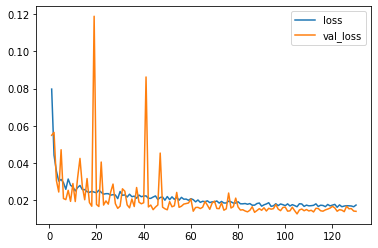

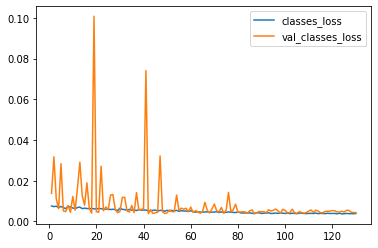

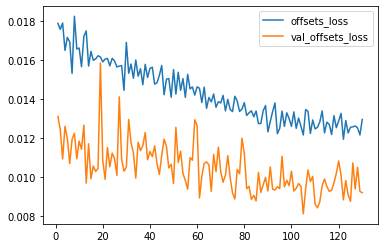

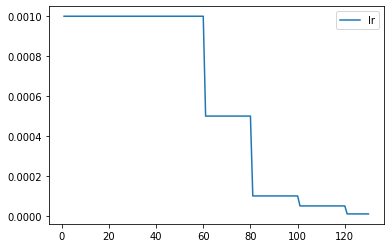

Epoch 132/200
Learning rate:  1e-05
 97/332 [=======>......................] - ETA: 53s - loss: 0.0169 - classes_loss: 0.0037 - offsets_loss: 0.0126

In [ ]:
reload (callbacks)

def lr_scheduler(epoch):    
    lr = 1e-3
    epoch_offset = 0    
    if epoch > (200 - epoch_offset):
        lr *= 1e-4
    elif epoch > (180 - epoch_offset):
        lr *= 5e-4
    elif epoch > (160 - epoch_offset):
        lr *= 1e-3
    elif epoch > (140 - epoch_offset):
        lr *= 5e-3
    elif epoch > (120 - epoch_offset):
        lr *= 1e-2
    elif epoch > (100 - epoch_offset):
        lr *= 5e-2
    elif epoch > (80 - epoch_offset):
        lr *= 1e-1
    elif epoch > (60 - epoch_offset):
        lr *= 5e-1
    print('Learning rate: ', lr)
    return lr

# lr_scheduler = (1e-3, 0.5, 20)

def get_callbacks ():
    return callbacks.conventional (
        os.path.join(os.getcwd(), 'temp', 'ssd'), 
        ds, lr_scheduler,
        monitor = 'val_loss', 
        early_stop = 0,
        plots = ['loss', 'classes_loss', 'offsets_loss'],
        reset_train_dir = True,
        custom_validation = False
    )

history = ssd.fit (
    ds.trainset,    
    validation_data = ds.validset,    
    epochs = 200, 
    initial_epoch = 0,
    steps_per_epoch = ds.steps,
    callbacks = get_callbacks ()
)

In [ ]:
ssd.evaluate (ds.validset)

In [ ]:
service_model.Model ().save (os.path.join(os.getcwd(), 'models'), ssd, ds, assets = [service_model.__file__])

### Service Model

In [ ]:
from tfserver import service_models
reload (service_model)

dnn.clear_session ()
# ssd = service_models.load (os.path.join(os.getcwd(), 'models'))
ssd_ = service_model.load (os.path.join(os.getcwd(), 'models'))

In [ ]:
%matplotlib inline

reload (service_model)
_ = ssd_.evaluate ('dataset/drinks/0010034.jpg', True)

### Evaluate

- rescale, stretch: mIoU: 0.409972 1 Precision: 0.754902 1 Recall : 0.761438 1

In [ ]:
import rs4
reload (service_model)

s_precision, s_recall, s_iou = 0, 0, 0
for idx, key in rs4.tqdm (enumerate (valid_xs), total = len (valid_xs)):
    labels = np.array(valid_ys [idx])
    gt_boxes = labels[:, 0:-1]
    gt_class_ids = labels[:, -1]    
    image_file = os.path.join(args.data_path, key)    
    class_ids, boxes, scores, class_names = ssd_.evaluate (image_file)
    
    boxes = np.reshape(np.array(boxes), (-1,4))
    iou = abiou.iou (gt_boxes, boxes)
    if iou.size ==0:
        continue
    maxiou_class = np.argmax (iou, axis=1)
    
    tp = 1e-8
    fp = 1e-8    
    s_image_iou = []
    for n in range(iou.shape[0]):
        # ground truth bbox has a label
        if iou[n, maxiou_class[n]] > 0:
            s_image_iou.append(iou[n, maxiou_class[n]])
            if gt_class_ids[n] == class_ids [maxiou_class[n]]:
                tp += 1
            else:
                fp += 1

    # objects that we missed (false negative)
    fn = abs(len(gt_class_ids) - tp - fp)
    s_iou += (np.sum(s_image_iou) / iou.shape[0])
    s_precision += (tp/(tp + fp))
    s_recall += (tp/(tp + fn))

n_test = len (valid_ys)
print ("mIoU: %f" % (s_iou/n_test), args.verbose)
print ("Precision: %f" % (s_precision/n_test), args.verbose)
print ("Recall : %f" % (s_recall/n_test), args.verbose)